In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN


Mounted at /content/drive


In [14]:
df = pd.read_csv('/content/drive/MyDrive/Data/PTDLKD_AIR_QTY/hanoi_quality.csv')
df1 = df['pm25']

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
df1_scaled = scaler.fit_transform(np.array(df1).reshape(-1, 1))


In [16]:
train_size = int(0.7 * len(df1_scaled))
test_size = len(df1_scaled) - train_size

train_data = df1_scaled[:train_size]
test_data = df1_scaled[train_size:]


In [17]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [18]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [19]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')


In [20]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)


Epoch 1/100
19/19 [==============================] - 3s 69ms/step - loss: 0.0664 - val_loss: 0.0457
Epoch 2/100
19/19 [==============================] - 1s 52ms/step - loss: 0.0221 - val_loss: 0.0378
Epoch 3/100
19/19 [==============================] - 1s 60ms/step - loss: 0.0179 - val_loss: 0.0355
Epoch 4/100
19/19 [==============================] - 1s 61ms/step - loss: 0.0157 - val_loss: 0.0323
Epoch 5/100
19/19 [==============================] - 1s 49ms/step - loss: 0.0145 - val_loss: 0.0315
Epoch 6/100
19/19 [==============================] - 1s 56ms/step - loss: 0.0139 - val_loss: 0.0311
Epoch 7/100
19/19 [==============================] - 1s 66ms/step - loss: 0.0137 - val_loss: 0.0298
Epoch 8/100
19/19 [==============================] - 1s 65ms/step - loss: 0.0129 - val_loss: 0.0294
Epoch 9/100
19/19 [==============================] - 1s 75ms/step - loss: 0.0124 - val_loss: 0.0289
Epoch 10/100
19/19 [==============================] - 1s 73ms/step - loss: 0.0123 - val_loss: 0.0290

In [21]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)


14/14 [==============================] - 0s 6ms/step


In [22]:
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)


In [23]:
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Testing RMSE:', test_rmse)


Testing RMSE: 71.18387297887165


In [24]:
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

lst_output = []
i = 0
while(i < 30):
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1


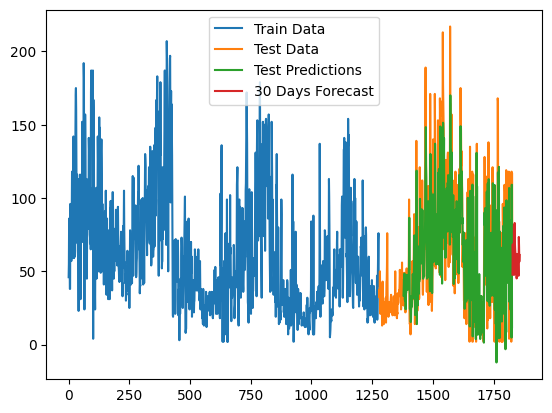

In [26]:
# Adjust plotting indices and make sure dimensions match
plt.plot(scaler.inverse_transform(train_data), label='Train Data')
plt.plot(np.arange(train_size, train_size+len(test_data)), scaler.inverse_transform(test_data), label='Test Data')

# Adjust the plotting range for test predictions
plt.plot(np.arange(train_size+time_step, train_size+len(test_data)-1), y_pred, label='Test Predictions')

# Forecast next 30 days
plt.plot(np.arange(len(df1_scaled), len(df1_scaled)+30), scaler.inverse_transform(lst_output), label='30 Days Forecast')

plt.legend()
plt.show()
